<a href="https://colab.research.google.com/github/miquelpuigmena/IDL/blob/master/IDL_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Analysis of the performance of different Loss Functions for the MNIST Classification Problem**

Loss Functions available in Pytorch: https://pytorch.org/docs/stable/nn.html#loss-functions

We'll use PyTorch to define and train a model based on Convolutional Neural Networks for solving the problem. Let's import the PyTorch library along with all its dependencies. Matplotlib will be used for plotting purposes.

In [0]:
#Install libraries if needed
!pip install pillow==5.4.1
!pip install matplotlib
!pip install torch
!pip install torchvision

In [0]:
#Import libraries
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Let's now define the Deep Neural Network that we want to train. We must first, inside the *init constructor*, define the layers that our network will have. For solving the MNIST Classification problem, we'll use two **2D convolutional layers** followed by two **feed-forward layers**.

The first layer is a 2D convolutional layer will handle the input (a B/W image of a digit from the MNIST database, thus an input of 1 channel) and produce an output of 20 channels. The second convolutional layer will handle these 20 channels and output 50 channels. The third layer, a feed-forward one, will handle an input of 4\*4*50 channels and output 500 channels. The fourth layer will deal with it and produce a final output of 10 layers, which matches the possible digits that can predicted (from 0 to 9).

The *forward* method of the class defines the **forward pass**, i.e the actions to be performed at the output of each layer and before the next one. After each convolutional layer, a ReLU (Rectified Linear Unit) activation function is applied, and then a maximum pooling of size 2x2 is performed. After the pooling of the second convolutional layer, the shape of the output tensor is changed, from two dimensions to a single dimension so as that it can be fed to the feed-forward layers. After the first feed-forward layer, a ReLU activation function is applied. Finally, the last layer, after the second feed-forward layer, is a Softmax layer.





In [0]:
class Net(nn.Module):
    def __init__(self):
      #Definition of the layers of the NN
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
      #Definition of activation functions, poolings, intermediate layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

We decided to initialize values on each iteration using xavier_uniform_ function.

In [0]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

Now, we must define how the Deep Neural Network is trained, which involves defining the **backward pass**.

For the training, different Loss Functions will be used and their results compared. To compare the results, a *losses* vector is defined, so that the loss evolution over training steps will be later plotted for each Loss Function. The LF to be checked are: *l1_loss*, *cross_entropy*, *cosine_similarity*, *hinge_embedding_loss*, and *nll_loss*.

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch, loss_type):
    losses = [] # Vector to save the losses for each train iteration
    model.train() # let's put the model in training mode
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        #We'll evaluate different loss functions
        if (loss_type is "l1_loss" or loss_type is "mse_loss"):
          #Let's transform the architecture of target appropiately
          #so that it can be used with functions l1_loss and mse_loss,
          #which are normally used for regression problems.
          #target is now a vector of mini-batch length with the ground truth
          #for each mini-batch element. It will be transformed to a tensor,
          #in which each element will be a vector with 0 for all the indexes not
          #corresponding to the ground truth and 1 for the element corresponding to it.
          
          newtarget = []
          for index, element in enumerate(target):
            vector = []
            for i in range(10):
              if (i == element):
                vector.append(1)
              else:
                vector.append(0)
            newtarget.append(vector)
          
          if torch.cuda.is_available():
            newtarget = torch.cuda.FloatTensor(newtarget)
          else:
            newtarget = torch.FloatTensor(newtarget)
        
        if loss_type is "l1_loss":          
          loss = F.l1_loss(output, newtarget)
        elif loss_type is "mse_loss":
          loss = F.mse_loss(output, newtarget)
        elif loss_type is "nll_loss":
          loss = F.nll_loss(output, target)       
        elif loss_type is "cross_entropy":
          loss = F.cross_entropy(output, target)
        elif loss_type is "multi_margin_loss":
          loss = F.multi_margin_loss(output, target)
        #elif loss_type is "cosine_similarity":
          #loss = F.cosine_similarity(...)
        else:
          return

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        #Every once in a while, show the progress of training and the loss 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

Once the model is trained, in order to evaluate its performance, we must devote part of the batch to validation. This part of the batch has not been used for training and the loss must be computed for it, to ensure that no **overfitting** is happening with the training batch.

In [0]:
def validate(model, device, loader, loss_type):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            if (loss_type is "l1_loss" or loss_type is "mse_loss"):
              #Let's transform the architecture of target appropiately
              #so that it can be used with functions l1_loss and mse_loss,
              #which are normally used for regression problems.
              #target is now a vector of mini-batch length with the ground truth
              #for each mini-batch element. It will be transformed to a tensor,
              #in which each element will be a vector with 0 for all the indexes not
              #corresponding to the ground truth and 1 for the element corresponding to it.

              newtarget = []
              for index, element in enumerate(target):
                vector = []
                for i in range(10):
                  if (i == element):
                    vector.append(1)
                  else:
                    vector.append(0)
                newtarget.append(vector)

              if torch.cuda.is_available():
                newtarget = torch.cuda.FloatTensor(newtarget)
              else:
                newtarget = torch.FloatTensor(newtarget)
            
            if loss_type is "l1_loss":
              validation_loss += F.l1_loss(output, newtarget, reduction='sum').item()
            elif loss_type is "mse_loss":
              validation_loss += F.mse_loss(output, newtarget, reduction='sum').item()
            elif loss_type is "nll_loss":
              validation_loss += F.nll_loss(output, target, reduction='sum').item()
            elif loss_type is "cross_entropy":
              validation_loss += F.cross_entropy(output, target, reduction='sum').item()
            elif loss_type is "multi_margin_loss":
              validation_loss += F.multi_margin_loss(output, target, reduction='sum').item()
            #elif loss_type is "cosine_similarity":
              #validation_loss += F.cosine_similarity(..., reduction='sum').item()
            else:
              return
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss

Once we have defined our DL model, the training and the validation procedures, we must import the data from the MNIST dataset to later train the model with different Loss Functions and evaluate its performance. For the training, a bacth of 128 data samples is to be used, while 1000 data samples are to be used for the validation.

In [0]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

This is where all computations happen. First, the computation device is defined, and set to a GPU if possible, the model is instantiated to the one that was defined above, and a Stochastic Gradient Descent optimizer (with a learning rate of 0.01 and a momentum of 0.5) is chosen.

For each Loss Function to be studied, the training losses and the validation losses are computed (the way it was defined above in the training and validation methods), for 10 epochs. The result for each Loss Function is then plotted.



In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

eval_funcs = ["l1_loss","mse_loss","nll_loss","cross_entropy","multi_margin_loss"]
results = {}
for eval_func in eval_funcs:
  print("############### EVALUATING LOSS FUNCTION "+eval_func+" ###############")
  train_losses = []
  valid_losses = []
  valid_x = []
  num_epochs = 10
  model.apply(init_weights)
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch, eval_func)
      train_losses.extend(epoch_losses) # Training losses (global)
      valid_loss = validate(model, device, valid_loader, eval_func)
      valid_losses.append([valid_loss]) # Validation losses (global)
      valid_x.append(len(train_losses) - 1)
  
  #Save the results of (train and validation losses) of this particular Loss Function
  results[eval_func] = {}
  results[eval_func]['train'] = {}
  results[eval_func]['train']['train_losses'] = train_losses
  results[eval_func]['valid'] = {}
  results[eval_func]['valid']['valid_losses'] = valid_losses
  results[eval_func]['valid']['valid_x'] = valid_x


############### EVALUATING LOSS FUNCTION l1_loss ###############
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.492707
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.408529
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.406659
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.405692
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.405372
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.405015

Validation set: Average loss: 24.0461, Accuracy: 952/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.404614
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.404430
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.404310
Train Epoch: 2 [30720/60000 (51%)]	Loss: 2.403973
Train Epoch: 2 [40960/60000 (68%)]	Loss: 2.403915
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.403813

Validation set: Average loss: 24.0373, Accuracy: 1052/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.403751
Train Epoch: 3 [10240/60000 (17%)]	Loss: 2.403624
Train Epoch: 3 [20480/60000 (34%)]	Loss: 2.403570
Train Epoch: 3 [30720/60000 (51%)]	Loss: 2.403502
Train Epoch: 3 

In [0]:
#print(results)

Here, the evolution of the train losses for each Loss Function is plotted. It can be seen that negative-log-likelihood loss, cross entropy loss, and multi margin loss (hinge loss) functions are the ones that work better.

L1 loss and Mean Square Error loss do not behave properly, as they are Loss Functions designed for regression problems, not classification ones. The MSE one, though, produces better results than the L1 one.

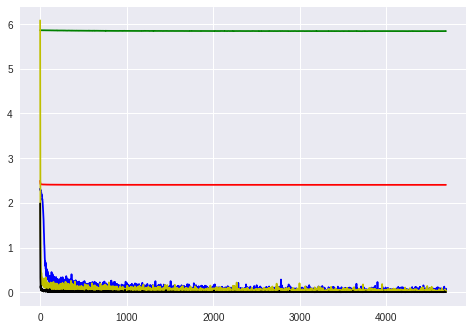

In [28]:
plt.gcf().clear()
plt.plot(results["l1_loss"]["train"]["train_losses"], 'r-')
plt.plot(results["mse_loss"]["train"]["train_losses"], 'g-')
plt.plot(results["nll_loss"]["train"]["train_losses"], 'b-')
plt.plot(results["cross_entropy"]["train"]["train_losses"], 'y-')
plt.plot(results["multi_margin_loss"]["train"]["train_losses"], 'k-')
plt.show()

L1 loss and MSE loss functions seem constant due to the scale of the last plot when including but do also vary and converge.

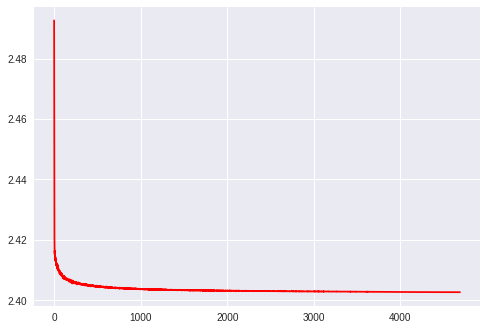

In [29]:
plt.gcf().clear()
plt.plot(results["l1_loss"]["train"]["train_losses"], 'r-')
plt.show()

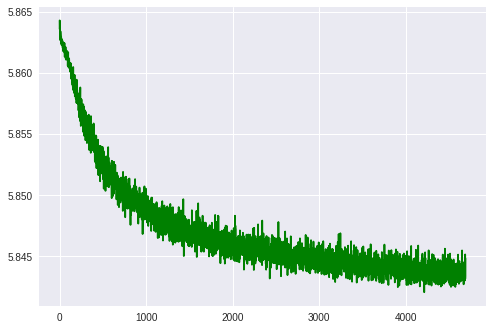

In [30]:
plt.gcf().clear()
plt.plot(results["mse_loss"]["train"]["train_losses"], 'g-')
plt.show()

Here is a zoom-in for the three loss functions mentioned above. It can be seen that the multi margin loss function works the best out of the three, producing a loss with a very low variability. Both cross entropy and multi margin loss (hinge loss) converge very quickly, while the negative log likelihood loss function needs a bit of time.

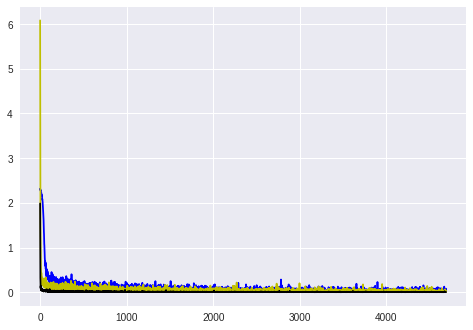

In [31]:
plt.gcf().clear()
plt.plot(results["nll_loss"]["train"]["train_losses"], 'b-')
plt.plot(results["cross_entropy"]["train"]["train_losses"], 'y-')
plt.plot(results["multi_margin_loss"]["train"]["train_losses"], 'k-')
plt.show()

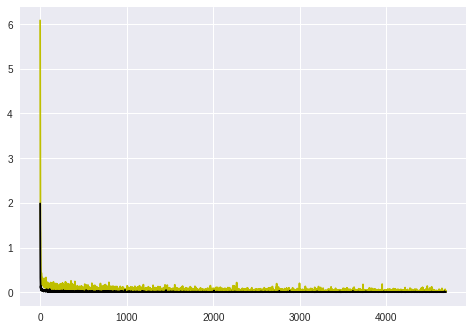

In [32]:
plt.gcf().clear()
plt.plot(results["cross_entropy"]["train"]["train_losses"], 'y-')
plt.plot(results["multi_margin_loss"]["train"]["train_losses"], 'k-')
plt.show()

Let's plot the same graphs for the validation batch



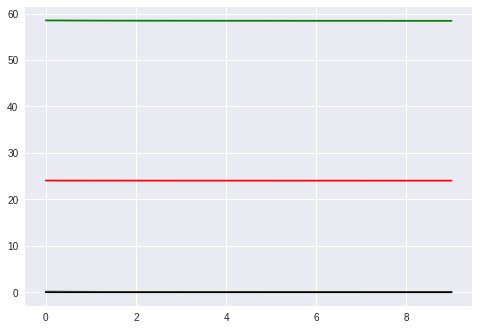

In [33]:
plt.gcf().clear()
plt.plot(results["l1_loss"]["valid"]["valid_losses"], 'r-')
plt.plot(results["mse_loss"]["valid"]["valid_losses"], 'g-')
plt.plot(results["nll_loss"]["valid"]["valid_losses"], 'b-')
plt.plot(results["cross_entropy"]["valid"]["valid_losses"], 'y-')
plt.plot(results["multi_margin_loss"]["valid"]["valid_losses"], 'k-')
plt.show()

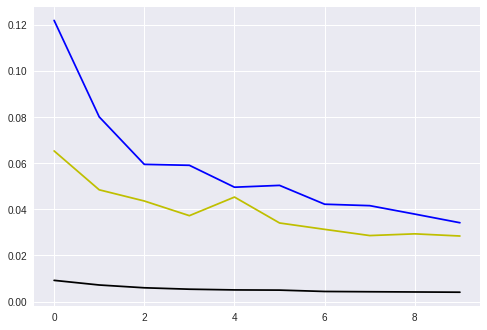

In [34]:
plt.gcf().clear()
plt.plot(results["nll_loss"]["valid"]["valid_losses"], 'b-')
plt.plot(results["cross_entropy"]["valid"]["valid_losses"], 'y-')
plt.plot(results["multi_margin_loss"]["valid"]["valid_losses"], 'k-')
plt.show()

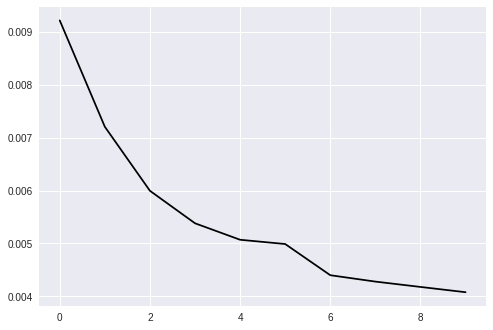

In [35]:
plt.gcf().clear()
plt.plot(results["multi_margin_loss"]["valid"]["valid_losses"], 'k-')
plt.show()